# Twitter Messages Data Analysis
Code link: https://github.com/hennypurwadi/twitter_analysis

### Collect Tweets from particular geocode location in Google map
https://www.google.co.uk/maps/place/10+Downing+Street/@51.5033668,-0.1298135,17z/data=!3m1!4b1!4m5!3m4!1s0x487604c541d11c47:0xf882a439cb8a5619!8m2!3d51.5033635!4d-0.1276248

In [ ]:
!pip3 install snscrape
!pip install tweepy
!pip install wordcloud

In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import string
import snscrape.modules.twitter as sntwitter
import tweepy
import unicodedata
import random
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams

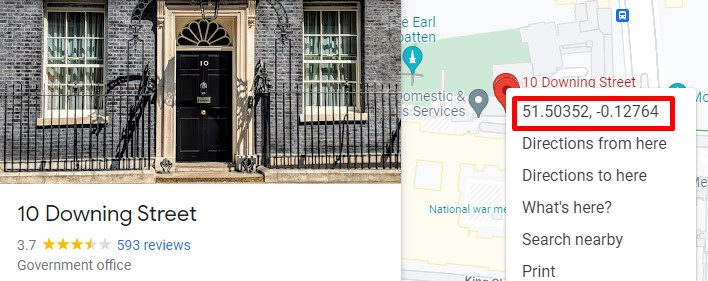

### Collect Tweets Without Twitter Developer Account /API: with snscrape

In [7]:
#Create and append to csv file and then write tweets into csv file
tweet_data = open('London_tweets_sns.csv', 'a', newline='', encoding='utf8')
csv.writer(tweet_data).writerow(['username','tweet','hashtags']) 

#Radius around 30 km around particular geocode
max_tweets = 40000
for n,tweet in enumerate(sntwitter.TwitterSearchScraper('geocode:51.50352,-0.12764,30km \
        + since:2022-07-29 until:2022-07-30 lang:en -filter:links -filter:replies').get_items()):
    
    if n > max_tweets:
        break
    csv.writer(tweet_data).writerow([tweet.user.username, tweet.content, tweet.hashtags])      
tweet_data.close()

In [8]:
df = pd.read_csv('London_tweets_sns.csv')
df = df.dropna(subset = ['hashtags']) #Only use tweets which contained hashtags
df.head()

,username,tweet,hashtags
2,TyroneChambers_,Independent Women\nWho run the world\n\nYour u...,['TALKSWITHASHAFTERDARK']
6,Z4ch3ryW,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,"['wordle', 'wordle406']"
17,FredoHnDz_20,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,"['workout', 'pickurlazyassup']"
21,MillieSansoye,There’s nothing straight about Xanadu #Uncoupled,['Uncoupled']
23,Teach_WA,Would someone please attest that driving is no...,"['gtfa', 'MarioKart']"


In [9]:
len(df)

10289

### Remove emojis from username
Can't clean username like make Capital letter become lowercase etc, since Capital letter etc is unique part of the name.

Only remove emojis from username.

In [10]:
emoji_pattern = re.compile("["
                        "\U0001F600-\U0001F64F"  # emoticons
                        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        "\U0001F300-\U0001F5FF"  # pictographs, symbols 
                        "\U0001F700-\U0001F77F"  # alchemical symbols
                        "\U0001F680-\U0001F6FF"  # transport & map symbols
                        "\U0001FA00-\U0001FA6F"  # Chess Symbols
                        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                        "\U00002702-\U000027B0"  # Dingbats
                        "\U0001F1E0-\U0001F1FF"  # flags (iOS)   
                        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs                        
                        "\U000024C2-\U0001F251" 
                        "]+", flags=re.UNICODE)  

def delete_emoji(string):
    return emoji_pattern.sub(r'', string)

df['username_no_emoji'] = df['username'].apply(delete_emoji)
df[['username','username_no_emoji']].head()

,username,username_no_emoji
2,TyroneChambers_,TyroneChambers_
6,Z4ch3ryW,Z4ch3ryW
17,FredoHnDz_20,FredoHnDz_20
21,MillieSansoye,MillieSansoye
23,Teach_WA,Teach_WA


## 1. Entity analysis to find 5 most active users.

In [11]:
#df['user'].unique()
userlist = df['username_no_emoji'].value_counts()
most_active_users = userlist.head(5)
most_active_users

AirplayNinja      164
HackWithJoey      101
DRUMSradio         94
floweroflondon     85
ska_tonic          57
Name: username_no_emoji, dtype: int64

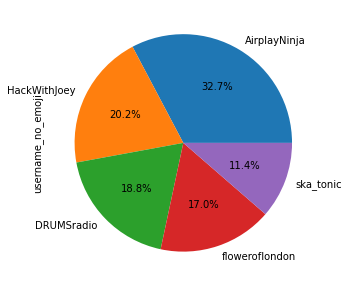

In [12]:
plot_users=most_active_users.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.rc('axes', unicode_minus=False)
plt.savefig("MostActiveUser_chart.jpeg",transparent=False, bbox_inches='tight',pad_inches=0.1)

## 2. Entity analysis to find 5 most used hastags

### Lite Cleaning for hashtags
Cleaning hashtags to get 5 most prevalent ones is lite cleaning

In [13]:
#Functun to convert to str
def lightclean(hashtags_data):  
    hashtags_data = str(hashtags_data).lower() #make str
    return hashtags_data

df['Cleaned_Hashtags'] = df['hashtags'].apply(lightclean)

htag_Texts_Cleaned=df['Cleaned_Hashtags'].values
htag_Texts_Cleaned=str(htag_Texts_Cleaned)
htag_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',htag_Texts_Cleaned)
htag_Texts_Cleaned= re.sub(r' +', ' ', htag_Texts_Cleaned)
htag_Texts_Cleaned= re.sub(r' text', ' ', htag_Texts_Cleaned) #remove 'text'
htag_Texts_Cleaned= re.sub(r' indices', ' ', htag_Texts_Cleaned) #remove 'indices'
print("Cleaned hashtags:" + "\n" + htag_Texts_Cleaned)

Cleaned hashtags:
 talkswithashafterdark wordle wordle workout pickurlazyassup firstworldproblems genocide russians armukrainenow hacked hackingtime snapchat twitter instagram aws g news 


### Counting the number of hastags

In [14]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

hashtag_count = word_count(htag_Texts_Cleaned)
print(hashtag_count)

{'talkswithashafterdark': 1, 'wordle': 2, 'workout': 1, 'pickurlazyassup': 1, 'firstworldproblems': 1, 'genocide': 1, 'russians': 1, 'armukrainenow': 1, 'hacked': 1, 'hackingtime': 1, 'snapchat': 1, 'twitter': 1, 'instagram': 1, 'aws': 1, 'g': 1, 'news': 1}


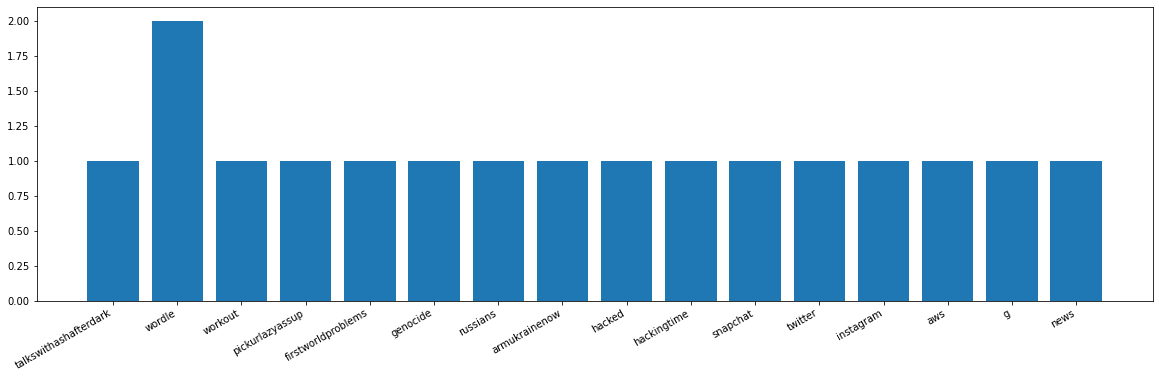

In [15]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.bar(hashtag_count.keys(), hashtag_count.values())
fig.autofmt_xdate()
plt.savefig('hashtag_count_graph.jpeg')
plt.show()

In [16]:
MostPopularHashtags = sorted(hashtag_count, key=hashtag_count.get, reverse=True)[:5]
#' '.join(MostPopularHashtags)
MostPopularHashtags

['wordle',
 'talkswithashafterdark',
 'workout',
 'pickurlazyassup',
 'firstworldproblems']

In [17]:
#Convert list to str

MostPopularHashtags_str = ''
i = 0
for x in MostPopularHashtags:
    i = i+1
    if i < 5:
        MostPopularHashtags_str += '#'+ x + ', '
    else:
        MostPopularHashtags_str += '#'+ x
    
print("5 Most popular hastags are : " + MostPopularHashtags_str)

5 Most popular hastags are : #wordle, #talkswithashafterdark, #workout, #pickurlazyassup, #firstworldproblems


In [18]:
TopPopularHashtags = sorted(hashtag_count, key=hashtag_count.get, reverse=True)[:1]
TopPopularHashtags_str = ' '.join(str(e) for e in TopPopularHashtags) #convert list to str
TopPopularHashtags_str
print("Top popular hastags is : " + TopPopularHashtags_str)

Top popular hastags is : wordle


## 3. Entity analysis to extract five most prevalent topics in the tweets

### Preprocessing, Cleaning with regex
Make the text lowercase, remove line breaks, punctuation, usernames, url, extra spaces, etc

In [19]:
def cleaning(tweets_data):   
    tweets_data = str(tweets_data).lower() #Make the text lowercase.
    tweets_data = re.sub(r'#[A-Za-z0–9]+', '', tweets_data) #remove hashtags
    tweets_data=re.sub(r'@[A-Za-z0–9]+', '',tweets_data) #remove usernames    
    tweets_data=re.sub(r'@\w+', ' ', tweets_data) #remove usernames
    tweets_data= re.sub(r'\b\w{1}\b', '', tweets_data) #remove stopwords   
    tweets_data = re.sub(r'&(?![A-Za-z]+[0-9]*;|#[0-9]+;|#x[0-9a-fA-F]+;)', '', tweets_data)
    tweets_data = re.sub(r'&amp', '', tweets_data) 
    tweets_data = re.sub('\n', '', tweets_data) #Remove line breaks.
    tweets_data = re.sub('[%s]' % re.escape(string.punctuation), '', tweets_data) #remove punctuation
    tweets_data = re.sub('\[.*?\]', '', tweets_data)
    tweets_data=re.sub(r'http\S+', ' ', tweets_data) #remove all Url
    tweets_data = re.sub(r'https?:\/\/.*[\r\n]*', '', tweets_data) #remove website
    tweets_data = re.sub('https?://\S+|www\.\S+', '', tweets_data)  #remove all websites 
    tweets_data = re.sub(r' +', ' ', tweets_data) #remove extra space
    tweets_data = re.sub('<.*?>+', '', tweets_data)    
    tweets_data = re.sub('\w*\d\w*', '', tweets_data)
    tweets_data = re.sub(r'^RT[\s]+', '', tweets_data)    
    tweets_data = re.sub(r'[^a-z A-Z]', ' ',tweets_data) #Remove all not characters
    tweets_data = re.sub(emoji_pattern, '', tweets_data)#remove emojis
          
    return tweets_data

df['clean1_tweet'] = df['tweet'].apply(cleaning)
df_cleaned_tweets=df[['tweet','clean1_tweet']]
df_cleaned_tweets.head(20)

,tweet,clean1_tweet
2,Independent Women\nWho run the world\n\nYour u...,independent womenwho run the worldyour ultimat...
6,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,wordle
17,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,can say no to an empty gym vamos
21,There’s nothing straight about Xanadu #Uncoupled,there nothing straight about xanadu
23,Would someone please attest that driving is no...,would someone please attest that driving is no...
37,Watched Vikrant Rona in London🇬🇧❤️ with housef...,watched vikrant rona in london with housef...
39,Wordle 406 3/6\n\n⬜⬜🟩⬜⬜\n⬜⬜🟩⬜⬜\n🟩🟩🟩🟩🟩 ...,wordle nite nite and thank...
46,Baby mama just catching strays damnnn\n\nOop p...,baby mama just catching strays damnnnoop plot ...
49,Finally finished #Insider. I have to admit tha...,finally finished have to admit that my brain s...
52,"History has its eyes on you.\n\nSo, so good. O...",history has its eyes on youso so good one of t...


### Remove stopwords with nltk

In [20]:
stopwords = nltk.corpus.stopwords.words('english') 
df['clean2_tweet'] = df['clean1_tweet'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stopwords))

df_cleaned_tweets=df[['tweet','clean2_tweet']]
df_cleaned_tweets.head()

,tweet,clean2_tweet
2,Independent Women\nWho run the world\n\nYour u...,independent womenwho run worldyour ultimate wo...
6,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,wordle
17,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,say empty gym vamos
21,There’s nothing straight about Xanadu #Uncoupled,nothing straight xanadu
23,Would someone please attest that driving is no...,would someone please attest driving


### Stemming with nltk

In [21]:
stm = PorterStemmer()
df['clean3_tweet'] = df['clean2_tweet'].apply(
    lambda x: " ".join([stm.stem(word) for word in x.split()]))

df_cleaned_tweets=df[['tweet','clean3_tweet']]
df_cleaned_tweets.head()

,tweet,clean3_tweet
2,Independent Women\nWho run the world\n\nYour u...,independ womenwho run worldyour ultim woman em...
6,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,wordl
17,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,say empti gym vamo
21,There’s nothing straight about Xanadu #Uncoupled,noth straight xanadu
23,Would someone please attest that driving is no...,would someon pleas attest drive


### Lemitization with nltk

In [22]:
##lemmatization to bring the words in their root form  
lem = WordNetLemmatizer()
df['cleaned_tweet'] = df['clean3_tweet'].apply(
    lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))
df_cleaned_tweets=df[['tweet','cleaned_tweet']]
df_cleaned_tweets.head()

,tweet,cleaned_tweet
2,Independent Women\nWho run the world\n\nYour u...,independ womenwho run worldyour ultim woman em...
6,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,wordl
17,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,say empti gym vamo
21,There’s nothing straight about Xanadu #Uncoupled,noth straight xanadu
23,Would someone please attest that driving is no...,would someon plea attest drive


### Vectorize cleaned tweets with CountVectorizer with ngrame_range

ngram_range of (1, 1) means only unigrams.
(1, 2) means unigrams and bigrams.
(1, 3) means unigrams, bigrams, and trigrams.
(2, 2) means only bigrams. 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [23]:
countv = CountVectorizer(min_df=1,max_df=0.95,ngram_range=(1,3),stop_words='english')
countv_tweet = countv.fit_transform(df['cleaned_tweet'])
countv_tweet

<10289x127282 sparse matrix of type '<class 'numpy.int64'>'
	with 208432 stored elements in Compressed Sparse Row format>

In [24]:
countv_tweet.shape

(10289, 127282)

### Vectorize cleaned tweets with Tf-IDF with ngram_range

In [25]:
tfidf = TfidfVectorizer(min_df=1 ,max_df=0.95, ngram_range=(1,3),stop_words='english')
tfidf_tweet = tfidf.fit_transform(df['cleaned_tweet'])
tfidf_tweet

<10289x127282 sparse matrix of type '<class 'numpy.float64'>'
	with 208432 stored elements in Compressed Sparse Row format>

## Topic extraction with LDA (Latent Dirichlet Allocation) with Countvectorizer

In [26]:
LDA_countv = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_countv.fit(countv_tweet)

LatentDirichletAllocation(n_components=5, random_state=42)

In [27]:
#len(LDA_countv.components_[0])
LDA_countv.components_

array([[0.2000014 , 0.20000052, 0.2000006 , ..., 0.20001401, 0.20000062,
        0.20000062],
       [0.20000133, 0.20000049, 0.20000056, ..., 0.2000134 , 0.20000061,
        0.20000061],
       [1.19992596, 0.20000051, 0.20000059, ..., 1.20189031, 1.19999759,
        1.19999759],
       [3.20006993, 2.19999797, 1.19999766, ..., 0.20001454, 0.20000056,
        0.20000056],
       [0.20000138, 0.20000051, 0.20000059, ..., 1.19806774, 0.20000062,
        0.20000062]])

In [28]:
eachtopic = LDA_countv.components_[0]
eachtopic.argsort()

array([  7833, 102669,  58035, ...,  65322,  53401,  24300], dtype=int64)

In [29]:
#eachtopic[183]
# Top 5 words for this topic:
eachtopic.argsort()[-5:]

array([ 61530, 121126,  65322,  53401,  24300], dtype=int64)

In [30]:
word_top = eachtopic.argsort()[-5:]
for index in word_top:
    print(countv.get_feature_names()[index])

like
watch
love
indiyah
dami


In [50]:
for index,topic in enumerate(LDA_countv.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([countv.get_feature_names()[i] for i in topic.argsort()[-10:]])

Most prevalent topic #0: 
['paig', 'year', 'luca', 'gemma', 'dami indiyah', 'like', 'watch', 'love', 'indiyah', 'dami']
Most prevalent topic #1: 
['way', 'good', 'let', 'peopl', 'win', 'year', 'love', 'time', 'like', 'know']
Most prevalent topic #2: 
['day', 'good', 'think', 'say', 'love', 'watch', 'time', 'luca', 'gemma', 'like']
Most prevalent topic #3: 
['love', 'andrew', 'ekin david', 'look', 'luca', 'date', 'gemma', 'vote', 'ekin', 'david']
Most prevalent topic #4: 
['paig', 'date', 'radio', 'final', 'bbc radio', 'bbc', 'need', 'luca', 'like', 'gemma']


In [82]:
topic_lda_cv = LDA_countv.transform(countv_tweet)
topic_lda_cv[0].argmax()
topic_lda_cv.argmax(axis=1)
df['Topic_lda_cv'] = topic_lda_cv.argmax(axis=1)
df[['tweet','cleaned_tweet','Topic_lda_cv']].head(40)

,tweet,cleaned_tweet,Topic_lda_cv
2,Independent Women\nWho run the world\n\nYour u...,independ womenwho run worldyour ultim woman em...,1
6,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,wordl,0
17,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,say empti gym vamo,4
21,There’s nothing straight about Xanadu #Uncoupled,noth straight xanadu,0
23,Would someone please attest that driving is no...,would someon plea attest drive,0
37,Watched Vikrant Rona in London🇬🇧❤️ with housef...,watch vikrant rona london hous crowd decent fi...,2
39,Wordle 406 3/6\n\n⬜⬜🟩⬜⬜\n⬜⬜🟩⬜⬜\n🟩🟩🟩🟩🟩 ...,wordl nite nite thank,1
46,Baby mama just catching strays damnnn\n\nOop p...,babi mama catch stray damnnnoop plot twist may...,2
49,Finally finished #Insider. I have to admit tha...,final finish admit brain switch drama bc mani ...,3
52,"History has its eyes on you.\n\nSo, so good. O...",histori eye youso good one best sing along eve...,3


## Topic extraction with LDA (Latent Dirichlet Allocation) with Tf-IDF

In [51]:
LDA_tfidf = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_tfidf.fit(tfidf_tweet)

LatentDirichletAllocation(n_components=5, random_state=42)

In [52]:
LDA_tfidf.components_

array([[0.31523983, 0.2000092 , 0.20001218, ..., 0.20002189, 0.20001144,
        0.20001144],
       [0.20001953, 0.20000912, 0.20001207, ..., 0.20002234, 0.2000115 ,
        0.2000115 ],
       [0.2000199 , 0.20000925, 0.20001224, ..., 0.20002271, 0.20001135,
        0.20001135],
       [0.6593427 , 0.43401769, 0.31697839, ..., 0.20002255, 0.20001117,
        0.20001117],
       [0.20001995, 0.20000941, 0.20001245, ..., 0.92301521, 0.34332957,
        0.34332957]])

In [53]:
eachtopics = LDA_tfidf.components_[0]
eachtopics.argsort()

array([ 57273, 122285,   7454, ...,  42469,  53401,  24300], dtype=int64)

In [54]:
#eachtopics[183]
# Top 5 words for this topic:
eachtopics.argsort()[-5:]

array([ 2960, 24375, 42469, 53401, 24300], dtype=int64)

In [83]:
for index,topic in enumerate(LDA_tfidf.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Most prevalent topic #0: 
['like', 'vote', 'luca', 'paig', 'love', 'alert', 'dami indiyah', 'gemma', 'indiyah', 'dami']
Most prevalent topic #1: 
['date', 'ekin', 'luca', 'david', 'like', 'vote', 'win', 'love', 'gemma', 'know']
Most prevalent topic #2: 
['come', 'gemma luca', 'vote', 'good', 'love', 'like', 'luca', 'gemma', 'time', 'watch']
Most prevalent topic #3: 
['electron', 'worldwid', 'african', 'luca', 'andrew', 'ekin', 'gemma', 'david', 'love', 'vote']
Most prevalent topic #4: 
['oh', 'david', 'revolut', 'paig', 'final', 'love', 'like', 'luca', 'gemma', 'date']


In [56]:
topic_lda_tfidf = LDA_tfidf.transform(tfidf_tweet)
topic_lda_tfidf.shape
topic_lda_tfidf[0].round(2)
topic_lda_tfidf[0].argmax()
topic_lda_tfidf.argmax(axis=1)

array([1, 2, 4, ..., 4, 2, 3], dtype=int64)

In [81]:
df['Topic_lda_tfif'] = topic_lda_tfidf.argmax(axis=1)
df[['tweet','cleaned_tweet','Topic_lda_tfif']].head(40)

,tweet,cleaned_tweet,Topic_lda_tfif
2,Independent Women\nWho run the world\n\nYour u...,independ womenwho run worldyour ultim woman em...,1
6,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,wordl,2
17,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,say empti gym vamo,4
21,There’s nothing straight about Xanadu #Uncoupled,noth straight xanadu,0
23,Would someone please attest that driving is no...,would someon plea attest drive,0
37,Watched Vikrant Rona in London🇬🇧❤️ with housef...,watch vikrant rona london hous crowd decent fi...,2
39,Wordle 406 3/6\n\n⬜⬜🟩⬜⬜\n⬜⬜🟩⬜⬜\n🟩🟩🟩🟩🟩 ...,wordl nite nite thank,2
46,Baby mama just catching strays damnnn\n\nOop p...,babi mama catch stray damnnnoop plot twist may...,2
49,Finally finished #Insider. I have to admit tha...,final finish admit brain switch drama bc mani ...,3
52,"History has its eyes on you.\n\nSo, so good. O...",histori eye youso good one best sing along eve...,3


## Topic extraction with NMF (Non-Negative Matric Factorization) with Countvectorizer

In [ ]:
nmf_model_cv = NMF(n_components=5, random_state=42) 
nmf_model_cv.fit(countv_tweet) 

In [72]:
for index,topic in enumerate(nmf_model_cv.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([countv.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Most prevalent topic #0: 
['gemma luca date', 'luca date', 'tasha', 'adam', 'paig', 'luca gemma', 'date', 'gemma luca', 'luca', 'gemma']
Most prevalent topic #1: 
['say', 'final', 'know', 'peopl', 'look', 'year', 'time', 'love', 'watch', 'like']
Most prevalent topic #2: 
['paig', 'indiyah', 'vote ekin', 'dami', 'ekin su', 'su', 'ekin david', 'vote', 'ekin', 'david']
Most prevalent topic #3: 
['mixplay african electron', 'african electron music', 'electron music', 'african electron', 'music worldwid', 'electron music worldwid', 'electron', 'worldwid', 'african', 'music']
Most prevalent topic #4: 
['alert servic alert', 'rail statu jul', 'rail statu', 'statu jul', 'rail', 'jul', 'statu', 'train', 'servic', 'alert']


In [80]:
topic_nmf_cv = nmf_model_cv.transform(countv_tweet)
topic_nmf_cv.argmax(axis=1)
df['Topic_nmf_cv'] = topic_nmf_cv.argmax(axis=1)
df[['tweet','cleaned_tweet','Topic_nmf_cv']].head(40)

,tweet,cleaned_tweet,Topic_nmf_cv
2,Independent Women\nWho run the world\n\nYour u...,independ womenwho run worldyour ultim woman em...,1
6,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,wordl,1
17,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,say empti gym vamo,1
21,There’s nothing straight about Xanadu #Uncoupled,noth straight xanadu,1
23,Would someone please attest that driving is no...,would someon plea attest drive,1
37,Watched Vikrant Rona in London🇬🇧❤️ with housef...,watch vikrant rona london hous crowd decent fi...,1
39,Wordle 406 3/6\n\n⬜⬜🟩⬜⬜\n⬜⬜🟩⬜⬜\n🟩🟩🟩🟩🟩 ...,wordl nite nite thank,1
46,Baby mama just catching strays damnnn\n\nOop p...,babi mama catch stray damnnnoop plot twist may...,1
49,Finally finished #Insider. I have to admit tha...,final finish admit brain switch drama bc mani ...,1
52,"History has its eyes on you.\n\nSo, so good. O...",histori eye youso good one best sing along eve...,1


## Topic extraction with NMF (Non-Negative Matric Factorization) with Tf-IDF

In [ ]:
nmf_model_tfidf= NMF(n_components = 5, random_state=42)
nmf_model_tfidf.fit(tfidf_tweet)

In [75]:
for index,topic in enumerate(nmf_model_tfidf.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])        

Most prevalent topic #0: 
['statu jul train', 'statu jul', 'train alert servic', 'alert servic alert', 'alert servic', 'jul train alert', 'servic alert', 'train alert', 'jul train', 'alert']
Most prevalent topic #1: 
['paig adam', 'luca date', 'like', 'adam', 'paig', 'luca gemma', 'date', 'gemma luca', 'luca', 'gemma']
Most prevalent topic #2: 
['su david', 'david ekin', 'ekin su', 'su', 'vote ekin david', 'vote ekin', 'ekin david', 'vote', 'ekin', 'david']
Most prevalent topic #3: 
['mixplay african', 'worldwid', 'electron', 'music worldwid', 'african electron music', 'electron music worldwid', 'african electron', 'electron music', 'african', 'music']
Most prevalent topic #4: 
['island', 'andrew', 'tasha', 'final', 'time', 'watch', 'dami indiyah', 'indiyah', 'dami', 'love']


In [79]:
topic_nmf_tfidf = nmf_model_tfidf.transform(tfidf_tweet)
topic_nmf_tfidf.argmax(axis=1)
df['Topics_nmf_tfidf'] = topic_nmf_tfidf.argmax(axis=1)
df[['tweet','cleaned_tweet','Topics_nmf_tfidf']].head(40)

,tweet,cleaned_tweet,Topics_nmf_tfidf
2,Independent Women\nWho run the world\n\nYour u...,independ womenwho run worldyour ultim woman em...,4
6,Wordle 406 4/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨🟩⬛🟨⬛\n🟩🟩🟩🟩🟩\n...,wordl,4
17,U can't say no to an empty gym. Vamos 🔥🤟🏼 #wor...,say empti gym vamo,4
21,There’s nothing straight about Xanadu #Uncoupled,noth straight xanadu,1
23,Would someone please attest that driving is no...,would someon plea attest drive,1
37,Watched Vikrant Rona in London🇬🇧❤️ with housef...,watch vikrant rona london hous crowd decent fi...,4
39,Wordle 406 3/6\n\n⬜⬜🟩⬜⬜\n⬜⬜🟩⬜⬜\n🟩🟩🟩🟩🟩 ...,wordl nite nite thank,4
46,Baby mama just catching strays damnnn\n\nOop p...,babi mama catch stray damnnnoop plot twist may...,4
49,Finally finished #Insider. I have to admit tha...,final finish admit brain switch drama bc mani ...,4
52,"History has its eyes on you.\n\nSo, so good. O...",histori eye youso good one best sing along eve...,4
